# HW - 9

# Name: Hinal Patel
# CWID: 10473912

In [1]:
# import all the libraries that we need
import pandas as pd   
import numpy as np    
import time          
import matplotlib.pyplot as plt 

In [2]:
from pyspark.sql import SparkSession  
from pyspark.sql.functions import col 
from pyspark.sql.functions import lit 
from pyspark.ml.classification import LogisticRegression # to classify the model
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler # for preparing data for classification
from pyspark.ml.evaluation import MulticlassClassificationEvaluator  # for evaluating classification models
from pyspark.ml import Pipeline

In [3]:
spark = SparkSession.builder.appName('HW 9').getOrCreate()

In [4]:
spark

# 1. Download the new test2_new.txt data which contains the ground-truth of the track ID recommendations. 

In [5]:
ground_truth_columns = ['userID', 'trackID', 'ground_truth']
ground_truth = pd.read_csv('test2_new.txt', sep='|', names=ground_truth_columns)


In [6]:
ground_truth

,userID,trackID,ground_truth
0,200031,30877,1
1,200031,8244,1
2,200031,130183,0
3,200031,198762,0
4,200031,34503,1
...,...,...,...
5995,212234,137371,0
5996,212234,42375,0
5997,212234,277867,1
5998,212234,83093,1


# 2. Use the userID in test2_new.txt to fetch the related rating scores in the training data for the same users.

In [7]:
scores_columns = ['userID', 'trackID', 'album_score', 'artist_score']
scores = pd.read_csv('output1.txt', sep='|', names=scores_columns)

In [8]:
rating_scores = ground_truth.merge(scores, on=['userID', 'trackID']).fillna(0)    

In [9]:
rating_scores

,userID,trackID,ground_truth,album_score,artist_score
0,200031,30877,1,90.0,50.0
1,200031,8244,1,90.0,0.0
2,200031,130183,0,0.0,0.0
3,200031,198762,0,0.0,0.0
4,200031,34503,1,90.0,50.0
...,...,...,...,...,...
5995,212234,137371,0,0.0,0.0
5996,212234,42375,0,0.0,0.0
5997,212234,277867,1,90.0,90.0
5998,212234,83093,1,90.0,90.0


In [10]:
rating_scores.to_csv('rating_scores.csv', index=None)   

Here we merge the 2 data frames with an inner join on the userID and trackID columns. 

This will give us a 6,000 line DF that contains the scores and ground truths and write this to csv file.


# This is where we collect ratings. csv and do some further configuration to prepare it for the various ML classification models.


In [11]:
rating_scores = spark.read.csv('rating_scores.csv', header=True, inferSchema=True)     

In [12]:
rating_scores.count()

6000

In [13]:
rating_scores_columns = rating_scores.columns

We may use .groupby() and .count() to see if the two classes (0 and 1) are balanced. They are, as we can see from the table above, since each class contains an equal number of entries.

In [14]:
pd.DataFrame(rating_scores.take(6000), columns=rating_scores_columns).groupby('ground_truth').count()

,userID,trackID,album_score,artist_score
ground_truth,,,,
0,3000,3000,3000,3000
1,3000,3000,3000,3000


In [15]:
rating_scores.printSchema()

root
 |-- userID: integer (nullable = true)
 |-- trackID: integer (nullable = true)
 |-- ground_truth: integer (nullable = true)
 |-- album_score: double (nullable = true)
 |-- artist_score: double (nullable = true)



In [16]:
rating_scores = rating_scores.withColumn('ground_truth', rating_scores['ground_truth'].cast('string'))

In [17]:
rating_scores.dtypes

[('userID', 'int'),
 ('trackID', 'int'),
 ('ground_truth', 'string'),
 ('album_score', 'double'),
 ('artist_score', 'double')]

After that, To do a feature conversion, use VectorAssembler() to merge several numeric columns into a vector column and used StringIndexer() to convert a string column of labels to a column of label indices.


In [18]:
feature_columns = ['album_score', 'artist_score']
stages = []
merge_inputs = feature_columns
assembler = VectorAssembler(inputCols=merge_inputs, outputCol='features') # merges multiple columns
stages += [assembler]

In [19]:
label_column = 'ground_truth'
label_string_idx = StringIndexer(inputCol=label_column, outputCol='label')
stages += [label_string_idx]

A pipeline is made up of a series of phases. We may utilize it to connect several Transformers and Estimators to optimize our ML process.


In [20]:
pipeline = Pipeline(stages=stages)               # initialize the pipeline
pipeline_model = pipeline.fit(rating_scores)     # fit the pipeline model
train_df = pipeline_model.transform(rating_scores) # transform the input DF with the pipeline model


In [21]:
selected_columns = ['label', 'features'] + rating_scores_columns
train_df = train_df.select(selected_columns)
train_df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- userID: integer (nullable = true)
 |-- trackID: integer (nullable = true)
 |-- ground_truth: string (nullable = true)
 |-- album_score: double (nullable = true)
 |-- artist_score: double (nullable = true)



In [22]:
pd.DataFrame(train_df.take(5), columns=train_df.columns).transpose()

,0,1,2,3,4
label,1.0,1.0,0.0,0.0,1.0
features,"[90.0, 50.0]","[90.0, 0.0]","(0.0, 0.0)","(0.0, 0.0)","[90.0, 50.0]"
userID,200031,200031,200031,200031,200031
trackID,30877,8244,130183,198762,34503
ground_truth,1,1,0,0,1
album_score,90.0,90.0,0.0,0.0,90.0
artist_score,50.0,0.0,0.0,0.0,50.0


An Estimator is a kind of method that may be fitted to a DataFrame to generate a Transformer.

A Transformer is an algorithm that can convert one DataFrame into another.

we can see that we now have 2 new columns:

label - Column of type double that contains the labels

features - Column of type vector that contains the features


# With a 70:30 split, we split the data into training and testing. 


In [23]:
train_df, test_df = train_df.randomSplit([0.7, 0.3], seed=2018)

In [24]:
print(f'Training Dataset Count: {train_df.count()}')
print(f'Test Dataset Count: {test_df.count()}')

Training Dataset Count: 4260
Test Dataset Count: 1740


In [25]:
 # inferSchema scans csv twice to get datatype of each column
prediction = spark.read.csv('output1.txt', sep='|', inferSchema=True)   
prediction.count()

120000

In [26]:
prediction = prediction.withColumnRenamed("_c0", "userID").withColumnRenamed("_c1", "trackID").withColumnRenamed("_c2", "albumScore").withColumnRenamed("_c3", "artistScore")
prediction_columns = prediction.columns
prediction_columns

['userID', 'trackID', 'albumScore', 'artistScore']

In [27]:
prediction = prediction.withColumn('prediction', lit('0'))
pd.DataFrame(prediction.take(5), columns=prediction.columns).transpose()

,0,1,2,3,4
userID,199810,199810,199810,199810,199810
trackID,208019,74139,9903,242681,18515
albumScore,0.0,0.0,0.0,0.0,0.0
artistScore,0.0,0.0,0.0,0.0,70.0
prediction,0,0,0,0,0


In [28]:
prediction.printSchema()

root
 |-- userID: integer (nullable = true)
 |-- trackID: integer (nullable = true)
 |-- albumScore: double (nullable = true)
 |-- artistScore: double (nullable = true)
 |-- prediction: string (nullable = false)



Above, we load in the file output1.txt, which is the 120,000-character-long file on which we wish to make predictions using our models. We must repeat the previous steps by configuring the pipeline and obtaining the label and features columns.


In [29]:
feature_columns = ['albumScore', 'artistScore']
stages = []
merge_inputs = feature_columns
assembler = VectorAssembler(inputCols=merge_inputs, outputCol='features')    # merges multiple columns into a vector column
stages += [assembler]

In [30]:
label_column = 'prediction'
label_string_idx = StringIndexer(inputCol=label_column, outputCol='label')
stages += [label_string_idx]

In [31]:
prediction_pipeline = Pipeline(stages=stages)                       # initialize the pipeline
prediction_pipeline_model = prediction_pipeline.fit(prediction)  # fit the pipeline model
prediction = prediction_pipeline_model.transform(prediction)  # transform the input DF with the pipeline model

In [32]:
selected_columns = ['label', 'features'] + prediction_columns
prediction = prediction.select(selected_columns)
prediction.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- userID: integer (nullable = true)
 |-- trackID: integer (nullable = true)
 |-- albumScore: double (nullable = true)
 |-- artistScore: double (nullable = true)



In [33]:
pd.DataFrame(prediction.take(5), columns=prediction.columns).transpose()

,0,1,2,3,4
label,0.0,0.0,0.0,0.0,0.0
features,"(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","[0.0, 70.0]"
userID,199810,199810,199810,199810,199810
trackID,208019,74139,9903,242681,18515
albumScore,0.0,0.0,0.0,0.0,0.0
artistScore,0.0,0.0,0.0,0.0,70.0


# 3. For the fetched rating score matrix, use the "1" and "0" recommendations in test2 to training your classifier.  You need to try 4 different classifiers in the pyspark.ml library as shown in the lecture notes to train your models. Then apply the trained models to what you fetched rating scores from the final project test data and make predictions.  Submit your new results at Kaggle. 


# Model 1 - Logistic Regression

In [34]:
from pyspark.ml.classification import LogisticRegression

In [35]:
start_time = time.time()

logistic_regression = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=100)  # initialize a logistic regression model
logistic_regression_model = logistic_regression.fit(train_df) # fit the training data with the model

end_time = time.time()
elapsed_time = end_time - start_time
print(f'Done! Time elapsed - {elapsed_time:.2f} seconds.')
logistic_regression_model.coefficients

Done! Time elapsed - 1.39 seconds.


DenseVector([0.0452, 0.0326])

In [36]:
beta = np.sort(logistic_regression_model.coefficients)   
beta

array([0.03256793, 0.04519982])

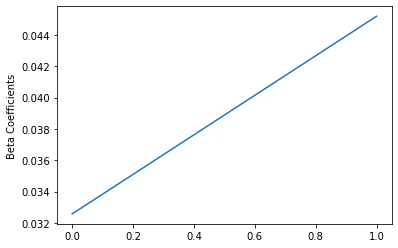

In [37]:
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

In [38]:
training_summary = logistic_regression_model.summary    # get summary (e.g. accuracy/precision/recall, objective histo
roc = training_summary.roc.toPandas()                   # get roc DF
roc

/Users/hinalpatel/opt/anaconda3/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


,FPR,TPR
0,0.000000,0.000000
1,0.000000,0.039683
2,0.000000,0.040149
3,0.000000,0.040616
4,0.000000,0.041083
...,...,...
88,0.076015,0.783847
89,0.076487,0.783847
90,0.076959,0.783847
91,1.000000,1.000000


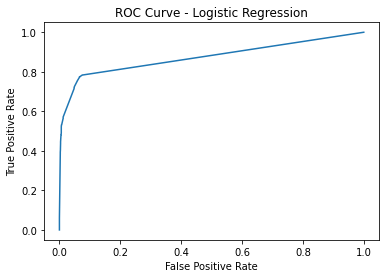

Training Set AUC = 0.8737133978552075


In [39]:
plt.plot(roc.FPR, roc.TPR)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.show()
print(f'Training Set AUC = {training_summary.areaUnderROC}')

In [40]:
predictions = logistic_regression_model.transform(test_df)    # transform test_df with logistic regression model
sort_predictions = predictions.select('userID', 'trackID', 'label', 'probability', 'rawPrediction', 'prediction').sort(col('userID').asc(), col('probability').desc())
sort_predictions.show(6)

+------+-------+-----+--------------------+--------------------+----------+
|userID|trackID|label|         probability|       rawPrediction|prediction|
+------+-------+-----+--------------------+--------------------+----------+
|200031| 130183|  0.0|[0.80218276453714...|[1.39999291666030...|       0.0|
|200031|   8244|  1.0|[0.06488875729218...|[-2.6679911209111...|       1.0|
|200031|  30877|  1.0|[0.01343471003408...|[-4.2963878477543...|       1.0|
|200055|  56695|  1.0|[0.00368752576332...|[-5.5991052292289...|       1.0|
|200065| 179571|  0.0|[0.80218276453714...|[1.39999291666030...|       0.0|
|200065| 119451|  1.0|[0.17782970128751...|[-1.5311211916575...|       1.0|
+------+-------+-----+--------------------+--------------------+----------+
only showing top 6 rows



In [41]:
logistic_predictions = logistic_regression_model.transform(prediction)    # transform prediction with logistic regression model
sort_logistic_predictions = logistic_predictions.select('userID', 'trackID', 'probability', 'rawPrediction', 'prediction').sort(col('userID').asc(), col('probability').desc())
sort_logistic_predictions.show(6)

+------+-------+--------------------+--------------------+----------+
|userID|trackID|         probability|       rawPrediction|prediction|
+------+-------+--------------------+--------------------+----------+
|199810| 208019|[0.80218276453714...|[1.39999291666030...|       0.0|
|199810| 242681|[0.80218276453714...|[1.39999291666030...|       0.0|
|199810|  74139|[0.80218276453714...|[1.39999291666030...|       0.0|
|199810|   9903|[0.80218276453714...|[1.39999291666030...|       0.0|
|199810|  18515|[0.29322699696820...|[-0.8797625009202...|       1.0|
|199810| 105760|[0.17782970128751...|[-1.5311211916575...|       1.0|
+------+-------+--------------------+--------------------+----------+
only showing top 6 rows



In [42]:
pd_sort_logistic_predictions = sort_logistic_predictions.toPandas().fillna(0.0)    # create a pandas df

In [43]:
pd_sort_logistic_predictions

,userID,trackID,probability,rawPrediction,prediction
0,199810,208019,"[0.8021827645371431, 0.1978172354628569]","[1.3999929166603091, -1.3999929166603091]",0.0
1,199810,74139,"[0.8021827645371431, 0.1978172354628569]","[1.3999929166603091, -1.3999929166603091]",0.0
2,199810,9903,"[0.8021827645371431, 0.1978172354628569]","[1.3999929166603091, -1.3999929166603091]",0.0
3,199810,242681,"[0.8021827645371431, 0.1978172354628569]","[1.3999929166603091, -1.3999929166603091]",0.0
4,199810,18515,"[0.2932269969682032, 0.7067730030317968]","[-0.8797625009202483, 0.8797625009202483]",1.0
...,...,...,...,...,...
119995,249010,86104,"[0.8021827645371431, 0.1978172354628569]","[1.3999929166603091, -1.3999929166603091]",0.0
119996,249010,293818,"[0.8021827645371431, 0.1978172354628569]","[1.3999929166603091, -1.3999929166603091]",0.0
119997,249010,110470,"[0.003687525763326008, 0.996312474236674]","[-5.599105229228973, 5.599105229228973]",1.0
119998,249010,186634,"[0.003687525763326008, 0.996312474236674]","[-5.599105229228973, 5.599105229228973]",1.0


In [44]:
columns_to_write = ['userID', 'trackID']
pd_sort_logistic_predictions.to_csv('logistic_regression_predictions.csv', index=False, header=None, columns=columns_to_write)    # write to csv (without headers)


In [45]:
f_logistic_regression_predictions = open('logistic_regression_predictions.csv')                  
f_logistic_regression_final_predictions = open('logistic_regression_final_predictions.csv', 'w')
# Write header
f_logistic_regression_final_predictions.write('TrackID,Predictor\n')

18

In [46]:
# Initialize the values
last_user_id = -1
track_id_out_vec = [0] * 6

start_time = time.time()
# Go through each line of the predictions file
for line in f_logistic_regression_predictions:
    arr_out = line.strip().split(',')    # remove any spaces/new lines and create list 
    user_id_out = arr_out[0]             # set user
    track_id_out = arr_out[1]            # set track
    
    if user_id_out != last_user_id:      # if new user reached
        i = 0                            # reset i
        
    track_id_out_vec[i] = track_id_out   # add trackID to trackID array
        
    i = i + 1                    # increment i
    last_user_id = user_id_out   # set last_user_id as current userID
    
    if i == 6:                            # if last entry for current user reached
        # Here we set the predictions 
        predictions = np.ones(shape=(6)) # initialize numpy array for predictions
        for index in range(0, 3):            
            predictions[index] = 0        # set first 3 values in array to 0 (other 3 are 1)
        
        # Here we write to the final predictions file for the 6 track predictions for the current user
        for ii in range(0, 6):         
            out_str = str(user_id_out) + '_' + str(track_id_out_vec[ii]) + ',' + str(int(predictions[ii]))
            f_logistic_regression_final_predictions.write(out_str + '\n')

        
end_time = time.time()
elapsed_time = end_time - start_time
print(f'Done! Time elapsed - {elapsed_time:.2f} seconds.')

Done! Time elapsed - 0.26 seconds.


In [47]:
f_logistic_regression_predictions.close()
f_logistic_regression_final_predictions.close()

# Model 2 - Decision Tree Classifier

In [48]:
from pyspark.ml.classification import DecisionTreeClassifier

In [49]:
start_time = time.time()
decision_tree = DecisionTreeClassifier(featuresCol='features', labelCol='label', maxDepth=3)
decision_tree_model = decision_tree.fit(train_df)
end_time = time.time()
elapsed_time = end_time - start_time
print(f'Done! Time elapsed - {elapsed_time:.2f} seconds.')

Done! Time elapsed - 0.60 seconds.


In [50]:
predictions_decision_tree = decision_tree_model.transform(test_df)
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')    # initialize an Evaluator for Multiclass Classification
accuracy = evaluator.evaluate(predictions_decision_tree)    # evaluate decision tree model on predictions
print(f'Test Error = {1.0 - accuracy:.2%}')

Test Error = 14.48%


In [51]:
sort_predictions_decision_tree = predictions_decision_tree.select('userID', 'trackID', 'label', 'probability', 'rawPrediction', 'prediction').sort(col('userID').asc(), col('probability').desc())
sort_predictions_decision_tree.show(6)

+------+-------+-----+--------------------+--------------+----------+
|userID|trackID|label|         probability| rawPrediction|prediction|
+------+-------+-----+--------------------+--------------+----------+
|200031| 130183|  0.0|[0.80858085808580...|[1960.0,464.0]|       0.0|
|200031|  30877|  1.0|[0.08880090497737...|[157.0,1611.0]|       1.0|
|200031|   8244|  1.0|[0.01470588235294...|    [1.0,67.0]|       1.0|
|200055|  56695|  1.0|[0.08880090497737...|[157.0,1611.0]|       1.0|
|200065| 179571|  0.0|[0.80858085808580...|[1960.0,464.0]|       0.0|
|200065| 119451|  1.0|[0.08880090497737...|[157.0,1611.0]|       1.0|
+------+-------+-----+--------------------+--------------+----------+
only showing top 6 rows



In [52]:
decision_tree_predictions = decision_tree_model.transform(prediction)    # transform prediction with decision tree model
decision_tree_predictions.select('userID', 'trackID', 'probability', 'rawPrediction', 'prediction').show(6)

+------+-------+--------------------+--------------+----------+
|userID|trackID|         probability| rawPrediction|prediction|
+------+-------+--------------------+--------------+----------+
|199810| 208019|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810|  74139|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810|   9903|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810| 242681|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810|  18515|[0.08880090497737...|[157.0,1611.0]|       1.0|
|199810| 105760|[0.08880090497737...|[157.0,1611.0]|       1.0|
+------+-------+--------------------+--------------+----------+
only showing top 6 rows



In [53]:
# col('userID').asc() sort the user ascending
# col('probability').desc() sort the probability descending (from large to small)
sort_decision_tree_predictions = decision_tree_predictions.select('userID', 'trackID', 'probability', 'rawPrediction', 'prediction').sort(col('userID').asc(), col('probability').desc())
sort_decision_tree_predictions.show(6)

+------+-------+--------------------+--------------+----------+
|userID|trackID|         probability| rawPrediction|prediction|
+------+-------+--------------------+--------------+----------+
|199810| 208019|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810| 242681|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810|  74139|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810|   9903|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810|  18515|[0.08880090497737...|[157.0,1611.0]|       1.0|
|199810| 105760|[0.08880090497737...|[157.0,1611.0]|       1.0|
+------+-------+--------------------+--------------+----------+
only showing top 6 rows



In [54]:
pd_sort_decision_tree_predictions = sort_decision_tree_predictions.toPandas().fillna(0.0)    # create pandas df

In [55]:
pd_sort_decision_tree_predictions

,userID,trackID,probability,rawPrediction,prediction
0,199810,208019,"[0.8085808580858086, 0.19141914191419143]","[1960.0, 464.0]",0.0
1,199810,74139,"[0.8085808580858086, 0.19141914191419143]","[1960.0, 464.0]",0.0
2,199810,9903,"[0.8085808580858086, 0.19141914191419143]","[1960.0, 464.0]",0.0
3,199810,242681,"[0.8085808580858086, 0.19141914191419143]","[1960.0, 464.0]",0.0
4,199810,18515,"[0.08880090497737557, 0.9111990950226244]","[157.0, 1611.0]",1.0
...,...,...,...,...,...
119995,249010,86104,"[0.8085808580858086, 0.19141914191419143]","[1960.0, 464.0]",0.0
119996,249010,293818,"[0.8085808580858086, 0.19141914191419143]","[1960.0, 464.0]",0.0
119997,249010,110470,"[0.08880090497737557, 0.9111990950226244]","[157.0, 1611.0]",1.0
119998,249010,186634,"[0.08880090497737557, 0.9111990950226244]","[157.0, 1611.0]",1.0


In [56]:
columns_to_write = ['userID', 'trackID']
pd_sort_decision_tree_predictions.to_csv('decision_tree_predictions.csv', index=False, header=None, columns=columns_to_write)    # write to csv (without header)
f_decision_tree_predictions = open('decision_tree_predictions.csv')   
f_decision_tree_final_predictions = open('decision_tree_final_predictions.csv', 'w')
# Write header
f_decision_tree_final_predictions.write('TrackID,Predictor\n')


18

In [57]:
# Initialize values
last_user_id = -1
track_id_out_vec = [0] * 6

start_time = time.time()

# Go through each line of the predictions file
for line in f_decision_tree_predictions:
    arr_out = line.strip().split(',')    # remove any spaces/new lines and create list 
    user_id_out = arr_out[0]             # set user
    track_id_out = arr_out[1]            # set track
    
    if user_id_out != last_user_id:             # if new user reached
        i = 0                                   # reset i
        
    track_id_out_vec[i] = track_id_out          # add trackID to trackID array
        
    i = i + 1                    # increment i
    last_user_id = user_id_out   # set last_user_id as current userID
    
    if i == 6:                               # if last entry for current user reached
        # Here we set the predictions 
        predictions = np.ones(shape=(6)) # initialize numpy array for predictions
        for index in range(0, 3):            
            predictions[index] = 0           # set first 3 values in array to 0 (other 3 are 1)
        
        # Here we write to the final predictions file for the 6 track predictions for the current user
        for ii in range(0, 6):         
            out_str = str(user_id_out) + '_' + str(track_id_out_vec[ii]) + ',' + str(int(predictions[ii]))
            f_decision_tree_final_predictions.write(out_str + '\n')

        
end_time = time.time()
elapsed_time = end_time - start_time
print(f'Done! Time elapsed - {elapsed_time:.2f} seconds.')

Done! Time elapsed - 0.28 seconds.


In [58]:
f_decision_tree_predictions.close()
f_decision_tree_final_predictions.close()

# Model 3 - Random Forest Classifier

In [59]:
from pyspark.ml.classification import RandomForestClassifier

In [60]:
start_time = time.time()

random_forest = RandomForestClassifier(featuresCol='features', labelCol='label')
random_forest_model = random_forest.fit(train_df)

end_time = time.time()
elapsed_time = end_time - start_time
print(f'Done! Time elapsed - {elapsed_time:.2f} seconds.')
predictions_random_forest = random_forest_model.transform(test_df)
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')    # initialize an Evaluator for Multiclass Classification
accuracy = evaluator.evaluate(predictions_random_forest)    # evaluate random forest model on predictions
print(f'Test Error = {1.0 - accuracy:.2%}')

Done! Time elapsed - 0.78 seconds.
Test Error = 14.48%


In [61]:
sort_predictions_random_forest = predictions_random_forest.select('userID', 'trackID', 'label', 'probability', 'rawPrediction', 'prediction').sort(col('userID').asc(), col('probability').desc())
sort_predictions_random_forest.show(6)

+------+-------+-----+--------------------+--------------------+----------+
|userID|trackID|label|         probability|       rawPrediction|prediction|
+------+-------+-----+--------------------+--------------------+----------+
|200031| 130183|  0.0|[0.80691299767542...|[16.1382599535085...|       0.0|
|200031|  30877|  1.0|[0.02139705733154...|[0.42794114663084...|       1.0|
|200031|   8244|  1.0|[0.00440623034254...|[0.08812460685080...|       1.0|
|200055|  56695|  1.0|[0.01443412768375...|[0.28868255367512...|       1.0|
|200065| 179571|  0.0|[0.80691299767542...|[16.1382599535085...|       0.0|
|200065| 119451|  1.0|[0.17656617529822...|[3.53132350596441...|       1.0|
+------+-------+-----+--------------------+--------------------+----------+
only showing top 6 rows



In [62]:
random_forest_predictions = decision_tree_model.transform(prediction)    # transform prediction with random forest model
random_forest_predictions.select('userID', 'trackID', 'probability', 'rawPrediction', 'prediction').show(12)

+------+-------+--------------------+--------------+----------+
|userID|trackID|         probability| rawPrediction|prediction|
+------+-------+--------------------+--------------+----------+
|199810| 208019|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810|  74139|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810|   9903|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810| 242681|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810|  18515|[0.08880090497737...|[157.0,1611.0]|       1.0|
|199810| 105760|[0.08880090497737...|[157.0,1611.0]|       1.0|
|199812| 276940|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199812| 142408|[0.08880090497737...|[157.0,1611.0]|       1.0|
|199812| 130023|[0.08880090497737...|[157.0,1611.0]|       1.0|
|199812|  29189|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199812| 223706|[0.08880090497737...|[157.0,1611.0]|       1.0|
|199812| 211361|[0.80858085808580...|[1960.0,464.0]|       0.0|
+------+-------+--------------------+---

In [63]:
# col('userID').asc() sort the user ascending
# col('probability').desc() sort the probability descending (from large to small)
sort_random_forest_predictions = random_forest_predictions.select('userID', 'trackID', 'probability', 'rawPrediction', 'prediction').sort(col('userID').asc(), col('probability').desc())
sort_random_forest_predictions.show(6)


+------+-------+--------------------+--------------+----------+
|userID|trackID|         probability| rawPrediction|prediction|
+------+-------+--------------------+--------------+----------+
|199810| 208019|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810| 242681|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810|  74139|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810|   9903|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810|  18515|[0.08880090497737...|[157.0,1611.0]|       1.0|
|199810| 105760|[0.08880090497737...|[157.0,1611.0]|       1.0|
+------+-------+--------------------+--------------+----------+
only showing top 6 rows



In [64]:
pd_sort_random_forest_predictions = sort_random_forest_predictions.toPandas().fillna(0.0)    # create pandas df
pd_sort_random_forest_predictions

,userID,trackID,probability,rawPrediction,prediction
0,199810,208019,"[0.8085808580858086, 0.19141914191419143]","[1960.0, 464.0]",0.0
1,199810,74139,"[0.8085808580858086, 0.19141914191419143]","[1960.0, 464.0]",0.0
2,199810,9903,"[0.8085808580858086, 0.19141914191419143]","[1960.0, 464.0]",0.0
3,199810,242681,"[0.8085808580858086, 0.19141914191419143]","[1960.0, 464.0]",0.0
4,199810,18515,"[0.08880090497737557, 0.9111990950226244]","[157.0, 1611.0]",1.0
...,...,...,...,...,...
119995,249010,86104,"[0.8085808580858086, 0.19141914191419143]","[1960.0, 464.0]",0.0
119996,249010,293818,"[0.8085808580858086, 0.19141914191419143]","[1960.0, 464.0]",0.0
119997,249010,110470,"[0.08880090497737557, 0.9111990950226244]","[157.0, 1611.0]",1.0
119998,249010,186634,"[0.08880090497737557, 0.9111990950226244]","[157.0, 1611.0]",1.0


In [65]:
columns_to_write = ['userID', 'trackID']
pd_sort_random_forest_predictions.to_csv('random_forest_predictions.csv', index=False, header=None, columns=columns_to_write)    # write to csv (without headers)
f_random_forest_predictions = open('random_forest_predictions.csv')   
f_random_forest_final_predictions = open('random_forest_final_predictions.csv', 'w')

# Write header
f_random_forest_final_predictions.write('TrackID,Predictor\n')


18

In [66]:
# Initialize values
last_user_id = -1
track_id_out_vec = [0] * 6
start_time = time.time()

# Go through each line of the predictions file
for line in f_random_forest_predictions:
    arr_out = line.strip().split(',')    # remove any spaces/new lines and create list 
    user_id_out = arr_out[0]             # set user
    track_id_out = arr_out[1]            # set track
    
    if user_id_out != last_user_id:             # if new user reached
        i = 0                                   # reset i
        
    track_id_out_vec[i] = track_id_out          # add trackID to trackID array
        
    i = i + 1                    # increment i
    last_user_id = user_id_out   # set last_user_id as current userID
    
    if i == 6:                               # if last entry for current user reached
        # Here we set the predictions 
        predictions = np.ones(shape=(6)) # initialize numpy array for predictions
        for index in range(0, 3):            
            predictions[index] = 0           # set first 3 values in array to 0 (other 3 are 1)
        
        # Here we write to the final predictions file for the 6 track predictions for the current user
        for ii in range(0, 6):         
            out_str = str(user_id_out) + '_' + str(track_id_out_vec[ii]) + ',' + str(int(predictions[ii]))
            f_random_forest_final_predictions.write(out_str + '\n')

        
end_time = time.time()
elapsed_time = end_time - start_time
print(f'Done! Time elapsed - {elapsed_time:.2f} seconds.')

Done! Time elapsed - 0.26 seconds.


In [67]:
f_decision_tree_predictions.close()
f_decision_tree_final_predictions.close()

# Model 4 - Gradient-Boosted Tree Classifier

In [68]:
from pyspark.ml.classification import GBTClassifier

In [69]:
start_time = time.time()

gradient_boosted_tree = GBTClassifier(maxIter=100)
gradient_boosted_tree_model = gradient_boosted_tree.fit(train_df)

end_time = time.time()
elapsed_time = end_time - start_time
print(f'Done! Time elapsed - {elapsed_time:.2f} seconds.')

Done! Time elapsed - 19.67 seconds.


In [70]:
predictions_gradient_boosted_tree = gradient_boosted_tree_model.transform(test_df)

In [71]:
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')    # initialize an Evaluator for Multiclass Classification
accuracy = evaluator.evaluate(predictions_gradient_boosted_tree)    # evaluate random forest model on predictions
print(f'Test Error = {1.0 - accuracy:.2%}')

Test Error = 14.48%


In [72]:
sort_predictions_gradient_boosted_tree = predictions_gradient_boosted_tree.select('userID', 'trackID', 'label', 'probability', 'rawPrediction', 'prediction').sort(col('userID').asc(), col('probability').desc())
sort_predictions_gradient_boosted_tree.show(6)

+------+-------+-----+--------------------+--------------------+----------+
|userID|trackID|label|         probability|       rawPrediction|prediction|
+------+-------+-----+--------------------+--------------------+----------+
|200031| 130183|  0.0|[0.80853359039673...|[0.72025491912707...|       0.0|
|200031|  30877|  1.0|[0.01165681655269...|[-2.2200694341913...|       1.0|
|200031|   8244|  1.0|[0.01165681655269...|[-2.2200694341913...|       1.0|
|200055|  56695|  1.0|[0.01632026531261...|[-2.0494463824457...|       1.0|
|200065| 179571|  0.0|[0.80853359039673...|[0.72025491912707...|       0.0|
|200065| 119451|  1.0|[0.19777096337535...|[-0.7001422692047...|       1.0|
+------+-------+-----+--------------------+--------------------+----------+
only showing top 6 rows



In [73]:
gradient_boosted_tree_predictions = gradient_boosted_tree_model.transform(prediction)    # transform prediction with gradient-boosted tree model
gradient_boosted_tree_predictions.select('userID', 'trackID', 'probability', 'rawPrediction', 'prediction').show(12)

+------+-------+--------------------+--------------------+----------+
|userID|trackID|         probability|       rawPrediction|prediction|
+------+-------+--------------------+--------------------+----------+
|199810| 208019|[0.80853359039673...|[0.72025491912707...|       0.0|
|199810|  74139|[0.80853359039673...|[0.72025491912707...|       0.0|
|199810|   9903|[0.80853359039673...|[0.72025491912707...|       0.0|
|199810| 242681|[0.80853359039673...|[0.72025491912707...|       0.0|
|199810|  18515|[0.24633418901301...|[-0.5591299711568...|       1.0|
|199810| 105760|[0.19777096337535...|[-0.7001422692047...|       1.0|
|199812| 276940|[0.80853359039673...|[0.72025491912707...|       0.0|
|199812| 142408|[0.01161609118736...|[-2.2218399428711...|       1.0|
|199812| 130023|[0.01161609118736...|[-2.2218399428711...|       1.0|
|199812|  29189|[0.80853359039673...|[0.72025491912707...|       0.0|
|199812| 223706|[0.12602709898363...|[-0.9682762071735...|       1.0|
|199812| 211361|[0.8

In [74]:
# col('userID').asc() sort the user ascending
# col('probability').desc() sort the probability descending (from large to small)
sort_gradient_boosted_tree_predictions = gradient_boosted_tree_predictions.select('userID', 'trackID', 'probability', 'rawPrediction', 'prediction').sort(col('userID').asc(), col('probability').desc())
sort_gradient_boosted_tree_predictions.show(6)

+------+-------+--------------------+--------------------+----------+
|userID|trackID|         probability|       rawPrediction|prediction|
+------+-------+--------------------+--------------------+----------+
|199810| 208019|[0.80853359039673...|[0.72025491912707...|       0.0|
|199810| 242681|[0.80853359039673...|[0.72025491912707...|       0.0|
|199810|  74139|[0.80853359039673...|[0.72025491912707...|       0.0|
|199810|   9903|[0.80853359039673...|[0.72025491912707...|       0.0|
|199810|  18515|[0.24633418901301...|[-0.5591299711568...|       1.0|
|199810| 105760|[0.19777096337535...|[-0.7001422692047...|       1.0|
+------+-------+--------------------+--------------------+----------+
only showing top 6 rows



In [75]:
pd_sort_gradient_boosted_tree_predictions = sort_gradient_boosted_tree_predictions.toPandas().fillna(0.0)    # create pandas df



In [76]:
pd_sort_gradient_boosted_tree_predictions

,userID,trackID,probability,rawPrediction,prediction
0,199810,208019,"[0.8085335903967381, 0.1914664096032619]","[0.7202549191270777, -0.7202549191270777]",0.0
1,199810,74139,"[0.8085335903967381, 0.1914664096032619]","[0.7202549191270777, -0.7202549191270777]",0.0
2,199810,9903,"[0.8085335903967381, 0.1914664096032619]","[0.7202549191270777, -0.7202549191270777]",0.0
3,199810,242681,"[0.8085335903967381, 0.1914664096032619]","[0.7202549191270777, -0.7202549191270777]",0.0
4,199810,18515,"[0.24633418901301743, 0.7536658109869826]","[-0.5591299711568518, 0.5591299711568518]",1.0
...,...,...,...,...,...
119995,249010,86104,"[0.8085335903967381, 0.1914664096032619]","[0.7202549191270777, -0.7202549191270777]",0.0
119996,249010,293818,"[0.8085335903967381, 0.1914664096032619]","[0.7202549191270777, -0.7202549191270777]",0.0
119997,249010,110470,"[0.016320265312616513, 0.9836797346873835]","[-2.0494463824457223, 2.0494463824457223]",1.0
119998,249010,186634,"[0.016320265312616513, 0.9836797346873835]","[-2.0494463824457223, 2.0494463824457223]",1.0


In [77]:
columns_to_write = ['userID', 'trackID']
pd_sort_gradient_boosted_tree_predictions.to_csv('gradient_boosted_tree_predictions.csv', index=False, header=None, columns=columns_to_write)    # write to csv (without headers)


In [78]:
f_gradient_boosted_tree_predictions = open('gradient_boosted_tree_predictions.csv')   
f_gradient_boosted_tree_final_predictions = open('gradient_boosted_tree_final_predictions.csv', 'w')

In [79]:
# Write header
f_gradient_boosted_tree_final_predictions.write('TrackID,Predictor\n')

18

In [80]:
# Initialize some values
last_user_id = -1
track_id_out_vec = [0] * 6

In [81]:
start_time = time.time()

# Go through each line of the predictions file
for line in f_gradient_boosted_tree_predictions:
    arr_out = line.strip().split(',')    # remove any spaces/new lines and create list 
    user_id_out = arr_out[0]             # set user
    track_id_out = arr_out[1]            # set track
    
    if user_id_out != last_user_id:             # if new user reached
        i = 0                                   # reset i
        
    track_id_out_vec[i] = track_id_out          # add trackID to trackID array
        
    i = i + 1                    # increment i
    last_user_id = user_id_out   # set last_user_id as current userID
    
    if i == 6:                               # if last entry for current user reached
        # Here we set the predictions 
        predictions = np.ones(shape=(6)) # initialize numpy array for predictions
        for index in range(0, 3):            
            predictions[index] = 0           # set first 3 values in array to 0 (other 3 are 1)
        
        # Here we write to the final predictions file for the 6 track predictions for the current user
        for ii in range(0, 6):         
            out_str = str(user_id_out) + '_' + str(track_id_out_vec[ii]) + ',' + str(int(predictions[ii]))
            f_gradient_boosted_tree_final_predictions.write(out_str + '\n')

        
end_time = time.time()
elapsed_time = end_time - start_time
print(f'Done! Time elapsed - {elapsed_time:.2f} seconds.')


Done! Time elapsed - 0.37 seconds.


In [82]:
f_gradient_boosted_tree_predictions.close()
f_gradient_boosted_tree_final_predictions.close()

# Analysis:

As per Kaggle Result for the 4 ML Classification Models,

     Classifier	          Prediction_Result
     Logistic Regression      	0.84490
     Decision Tree	            0.82127
     Random Forest	            0.82127
     Gradient-Boosted Tree	    0.84479


The Logistic Regression classification model seems to have performed the best.
as seen in the table, with the Gradient boosted tree model coming in a close second.
Of course, changing some of the parameters while generating the models might vary the findings.
